In [1]:
!pip install -q transformers datasets

In [2]:
!pip install transformers[torch]
!pip install accelerate -U

In [3]:
import random
import torch
from torch.utils.data import DataLoader
from transformers import BeitForImageClassification, BeitImageProcessor
from datasets import load_dataset
from torch.optim import Adam

dataset_path = "/kaggle/input/aid-scene-classification-datasets"
dataset = load_dataset('imagefolder', data_dir=dataset_path)

splits = dataset['train'].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']


Resolving data files:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
print(id2label)

{0: 'Airport', 1: 'BareLand', 2: 'BaseballField', 3: 'Beach', 4: 'Bridge', 5: 'Center', 6: 'Church', 7: 'Commercial', 8: 'DenseResidential', 9: 'Desert', 10: 'Farmland', 11: 'Forest', 12: 'Industrial', 13: 'Meadow', 14: 'MediumResidential', 15: 'Mountain', 16: 'Park', 17: 'Parking', 18: 'Playground', 19: 'Pond', 20: 'Port', 21: 'RailwayStation', 22: 'Resort', 23: 'River', 24: 'School', 25: 'SparseResidential', 26: 'Square', 27: 'Stadium', 28: 'StorageTanks', 29: 'Viaduct'}


preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `BeitImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([30]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([30, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 completed. Loss: 0.020189788192510605
Validation Accuracy: 0.94, F1 Score: 0.94, Precision: 0.94


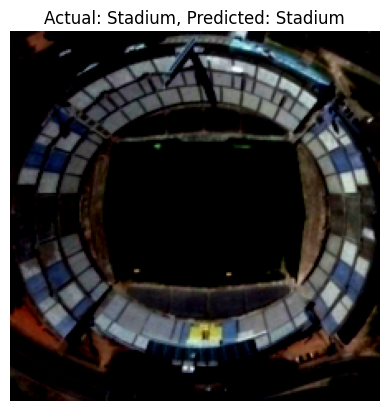

Epoch 2 completed. Loss: 0.13443925976753235
Validation Accuracy: 0.95, F1 Score: 0.95, Precision: 0.95


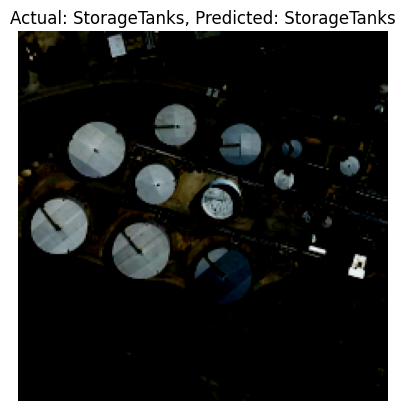

Training completed.


In [5]:
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import BeitForImageClassification, BeitImageProcessor
from torch.optim import Adam
from torchvision import transforms
from sklearn.metrics import f1_score, precision_score
processor = BeitImageProcessor.from_pretrained("microsoft/beit-base-patch16-224")

def preprocess_data(examples):
    images = [image.convert("RGB") for image in examples['image']]
    inputs = processor(images, return_tensors="pt")
    inputs['labels'] = torch.tensor(examples['label'], dtype=torch.long)
    return {'pixel_values': inputs['pixel_values'], 'labels': inputs['labels']}

train_ds = train_ds.with_transform(preprocess_data)
val_ds = val_ds.with_transform(preprocess_data)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([item['pixel_values'].squeeze(0) for item in batch]),
        'labels': torch.tensor([item['labels'] for item in batch], dtype=torch.long)
    }

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

model = BeitForImageClassification.from_pretrained(
    "microsoft/beit-base-patch16-224", 
    num_labels=len(dataset['train'].features['label'].names),
    ignore_mismatched_sizes=True
)

optimizer = Adam(model.parameters(), lr=5e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


def plot_image(image, actual_label, predicted_label):
    plt.imshow(image.permute(1, 2, 0)) 
    plt.title(f"Actual: {id2label[actual_label]}, Predicted: {id2label[predicted_label]}")
    plt.axis('off')
    plt.show()

for epoch in range(2): 
    model.train()
    for batch in train_loader:
        inputs = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(pixel_values=inputs, labels=labels)
        loss = outputs.loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch + 1} completed. Loss: {loss.item()}")

    # Validation
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(pixel_values=inputs)
            _, predicted = torch.max(outputs.logits, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    accuracy = (torch.tensor(all_predictions) == torch.tensor(all_labels)).float().mean().item()
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')

    print(f"Validation Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}, Precision: {precision:.2f}")


    random_index = random.randint(0, len(val_ds) - 1)
    random_sample = val_ds[random_index]  
    random_image = random_sample['pixel_values'] 
    random_label = random_sample['labels']  
    
   
    with torch.no_grad():
        outputs = model(pixel_values=random_image.unsqueeze(0).to(device)) 
        _, predicted_label = torch.max(outputs.logits, 1)

    
    plot_image(random_image.cpu(), random_label.item(), predicted_label.item())

print("Training completed.")